In [1]:
import json
import os
import numpy as np
import scipy
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

In [2]:
# change the size of figure
# pylab.rcParams['figure.figsize'] = (6.0, 4.0)  # normal case 
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

In [3]:
resultDir = "C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/local_project/DownloadedResults"
originalMapDir = "C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/local_project/Python"

# Metrics

### edit distance

In [4]:
def levenshtein(s, t):
        #''' From Wikipedia article; Iterative with two matrix rows. '''
    if s == t: return 0
    elif len(s) == 0: return len(t)
    elif len(t) == 0: return len(s)
    v0 = [None] * (len(t) + 1)
    v1 = [None] * (len(t) + 1)
    for i in range(len(v0)):
        v0[i] = i
    for i in range(len(s)):
        v1[0] = i + 1
        for j in range(len(t)):
            cost = 0 if s[i] == t[j] else 1
            v1[j + 1] = min(v1[j] + 1, v0[j + 1] + 1, v0[j] + cost)
        for j in range(len(v0)):
            v0[j] = v1[j]
                
    return v1[len(t)]

### Frechet Distance 

In [5]:
def euc_dist(pt1,pt2):
    return scipy.spatial.distance.cdist(pt1, pt2, 'euclidean')[0][0]

In [6]:
def Rescale(path1, path2):
    len1 = len(path1) 
    len2 = len(path2)

    if len1 > len2:
        len_ = len2
        len_max = len1
        path_min = path2 
        path_max = path1
        re_scale_factor = float(len2)/float(len1) 
    else:
        len_ = len1
        len_max = len2
        path_min = path1 
        path_max = path2
        re_scale_factor = float(len1)/float(len2)

    #re-scaling both path
    v = 0.0 
    path1_rescaled = []
    path2_rescaled = []

    #print(str(v) + ", " + str(w))
    while(v < float(len_)):
        path1_rescaled.append(path_min[int(v)])
        v = float(v) + re_scale_factor

    v = 0.0
    while(v < float(len_max)):
        path2_rescaled.append(path_max[int(v)])
        v = v + 1

    #because sometimes one of the path (rescaled) is longer by one than the other, we add to the shortest a copy of the last element
    if(len(path1_rescaled) > len(path2_rescaled)):
        path2_rescaled.append(path2_rescaled[len(path2_rescaled)-1])

    if(len(path2_rescaled) > len(path1_rescaled)):
        path1_rescaled.append(path1_rescaled[len(path1_rescaled)-1])
        
    return path1_rescaled, path2_rescaled

In [7]:
def _c(ca,i,j,p,q):

    x1, y1 = p[i].split(",")
    x2, y2 = q[j].split(",")
    if ca[i,j] > -1:
        return ca[i,j]
    elif i == 0 and j == 0:
        ca[i,j] = euc_dist([(int(x1),int(y1))], [(int(x2),int(y2))])
    elif i > 0 and j == 0:
        ca[i,j] = max( _c(ca,i-1,0,p,q), euc_dist([(int(x1),int(y1))], [(int(x2),int(y2))]))
    elif i == 0 and j > 0:
        ca[i,j] = max( _c(ca,0,j-1,p,q), euc_dist([(int(x1),int(y1))], [(int(x2),int(y2))]))
    elif i > 0 and j > 0:
        ca[i,j] = max(                                                     
            min(                                                           
                _c(ca,i-1,j,p,q),                                          
                _c(ca,i-1,j-1,p,q),                                        
                _c(ca,i,j-1,p,q)                                           
            ),                                                             
            euc_dist([(int(x1),int(y1))], [(int(x2),int(y2))])                                           
            )                                                          
    else:
        ca[i,j] = float('inf')

    return ca[i,j]

In [8]:
def frechetDist(p,q):
    
    p, q = Rescale(p,q)
    len_p = len(p)
    len_q = len(q)


    if len_p == 0 or len_q == 0:
        raise ValueError('Input curves are empty.')

    if len_p != len_q or len(p[0]) != len(q[0]):
        raise ValueError('Input curves do not have the same dimensions.')

    ca    = ( np.ones((len_p,len_q), dtype=np.float64) * -1 ) 
    dist = _c(ca,len_p-1,len_q-1,p,q)

    return dist

### Longest Common Subsequence

In [9]:
def lcs(a, b):
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    # read the substring out from the matrix
    result = ""
    x, y = len(a), len(b)
    while x != 0 and y != 0:
        if lengths[x][y] == lengths[x-1][y]:
            x -= 1
        elif lengths[x][y] == lengths[x][y-1]:
            y -= 1
        else:
            assert a[x-1] == b[y-1]
            result = a[x-1] + result
            x -= 1
            y -= 1
    return result

### ERP - edit distance with real penalty

In [10]:
def e_erp(t0,t1,g):
    """
    Usage
    -----
    The Edit distance with Real Penalty between trajectory t0 and t1.

    Parameters
    ----------
    param t0 : len(t0)x2 numpy_array
    param t1 : len(t1)x2 numpy_array

    Returns
    -------
    dtw : float
          The Dynamic-Time Warping distance between trajectory t0 and t1
    """

    n0 = len(t0)
    n1 = len(t1)
    C=np.zeros((n0+1,n1+1))

    t0_float = []
    t1_float = []

    k = 0
    while(k < n0):
        pos1 = t0[k]
        #pos2 = t1[k]
        x1, y1 = pos1.split(",")
        #x2, y2 = pos2.split(",")
        coord1 = [(float(x1), float(y1))]
        #coord2 = [(float(x2), float(y2))]
        t0_float.append(coord1)
        #t1_float.append(coord2)
        k = k + 1

    k = 0
    while(k < n1):
        #pos1 = t0[k]
        pos2 = t1[k]
        #x1, y1 = pos1.split(",")
        x2, y2 = pos2.split(",")
        #coord1 = [(float(x1), float(y1))]
        coord2 = [(float(x2), float(y2))]
        #t0_float.append(coord1)
        t1_float.append(coord2)
        k = k + 1
    
    #print(str(len(t0)) + ", " + str(len(t1)))

    C[1:,0]=sum(map(lambda x : abs(euc_dist(g,x)),t0_float))
    C[0,1:]=sum(map(lambda y : abs(euc_dist(g,y)),t1_float))
    for i in np.arange(n0)+1:
        for j in np.arange(n1)+1:
            derp0 = C[i-1,j] + euc_dist(t0_float[i-1],g)
            derp1 = C[i,j-1] + euc_dist(g,t1_float[j-1])
            derp01 = C[i-1,j-1] + euc_dist(t0_float[i-1],t1_float[j-1])
            C[i,j] = min(derp0,derp1,derp01)
    erp = C[n0,n1]
    return erp

# compare paths with DTW

### some conversion functions

In [11]:
def rotate(x, y, origin, mapName):
    
    # shift to origin
    x1 = x #- origin[0]
    y1 = y #- origin[1]

    #rotate
    x2 = y1
    y2 = -x1
    
    # shift back
    x3 = x2
    if mapName == "uffici2.map":
        y3 = y2 +53
    if mapName == "open2.map":
        y3 = y2 +57
    if mapName == "open1.map":
        y3 = y2 +48
    if mapName == "uffici1.map":
        y3 = y2 +54 

    return x3, y3

In [12]:
def conv2Axis(coordinateArray):
    res_x = []
    res_y = []
    for i in coordinateArray:

        res_x = np.append(res_x, i[0])
        res_y = np.append(res_y, i[1])
        
    
    return res_x, res_y

In [13]:
def stringArray2listArrayOfMap(target, origin, mapName):
    
    res = [[]]
    
    for i in range(len(target)):
        a, b = target[i].split(",")
        a, b = rotate(int(a),int(b), origin, mapName)
        
        if len(res[0]) == 0:
            res = [[int(a), int(b)]]
        else:
            res = np.append(res, [[int(a), int(b)]], axis=0)
    
    return res

In [14]:
def GetOriginalMap(mapName):
    if mapName == "open1.map":
        originalMapFile = "open1PythonFormat.map.txt"
    if mapName == "open2.map":
        originalMapFile = "open2PythonFormat.map.txt"
    if mapName == "uffici1.map":
        originalMapFile = "uffici1PythonFormat.map.txt"
    if mapName == "uffici2.map":
        originalMapFile = "uffici2PythonFormat.map.txt"
        
    return originalMapFile      

In [15]:
def SimilarPercentage(dtw_path, path1, path2, threshold = 4):
    count = 0.0
    for i in dtw_path:
        distance = euclidean(path1[i[0]], path2[i[1]])
        
        if distance < threshold:
            count += 1
    
    return count / len(dtw_path)
        

### draw the paths

In [16]:
def DrawPath(firstFilePath, secondFilePath, plot = True):
    completeFirstPath = resultDir + "/" + firstFilePath
    completeSecondPath = resultDir + "/" + secondFilePath
    
    if os.path.isfile(completeFirstPath):
        with open(completeFirstPath) as pathFile:
            firstData = json.load(pathFile)
            mapName = firstData["mapName"][0]
            first_array_position = firstData["position"]
            
            firstMapFile = GetOriginalMap(mapName)
                
    if os.path.isfile(completeSecondPath):
        with open(completeSecondPath) as pathFile:
            data = json.load(pathFile)
            mapName = data["mapName"][0]
            second_array_position = data["position"]
            
            secondMapFile = GetOriginalMap(mapName)
                
    if firstMapFile != secondMapFile:
        return print("two paths must be on the same map")   
    
    
    
    # compute other distance metrics
    distanceL = levenshtein(first_array_position, second_array_position)
    distanceERP = e_erp(first_array_position, second_array_position, np.zeros((1, 2), dtype=float))
    distanceF = frechetDist(first_array_position, second_array_position)
    distanceLCS = len(lcs(first_array_position, second_array_position))
    
    # compute dtw distance metrics
    origin = (0.0,0.0)
    first_array_position = stringArray2listArrayOfMap(first_array_position, origin, mapName)
    second_array_position = stringArray2listArrayOfMap(second_array_position, origin, mapName)
    distance, path = fastdtw(first_array_position, second_array_position, dist=euclidean)
    
    print("total dtw distance between two paths = %.2f" %distance)
    print("similarity percentage = %.2f%%" %(SimilarPercentage(path, first_array_position, second_array_position) * 100))
    print("edit distance between two paths = %.2f" %distanceL)
    print("ERP distance between two paths = %.2f" %distanceERP)
    print("Frechet distance between two paths = %.2f" %distanceF)
    print("LCSS distance between two paths = %.2f" %distanceLCS)
    
    if plot:
        # draw the original map
        if os.path.isfile(originalMapDir + "/" + firstMapFile):
            with open(originalMapDir + "/" + firstMapFile) as f:
                array = []
                content = f.readlines()

                content = [x.strip() for x in content]
                j = 0
                for line in content:
                    array = line.split(',')
                    for i in range(len(array)):
                        a = int(array[i])
                        if a == 1:
                            plt.plot(i, len(content)-j, 'ks')

                        if a == 4:
                            plt.plot(i, len(content)-j , 'gs')

                    j = j + 1 

        #draw the paths

        first_x, first_y = conv2Axis(first_array_position)
        second_x, second_y = conv2Axis(second_array_position)

        plt.plot(first_x, first_y, 'r-')
        plt.plot(second_x, second_y, 'b-')

        # draw DTW lines  
        for i in path:
            fx, fy = first_array_position[i[0]]
            sx, sy = second_array_position[i[1]]

            plt.plot([fx, sx], [fy, sy], 'g-')

        plt.show()

total dtw distance between two paths = 542.17
similarity percentage = 62.81%
edit distance between two paths = 96.00
ERP distance between two paths = 978.88
Frechet distance between two paths = 26.31
LCSS distance between two paths = 76.00


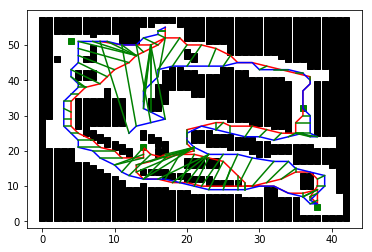

In [29]:
pylab.rcParams['figure.figsize'] = (15.0, 8.0)
DrawPath("Result6t.txt", "Result10t.txt")

#  Draw similar part between paths

In [18]:
def GetOriginalMapMatrix(mapName):
    
    originalMapFile = GetOriginalMap(mapName)
    if os.path.isfile(originalMapDir + "/" + originalMapFile):
        with open(originalMapDir + "/" + originalMapFile) as f:
            array = []
            content = f.readlines()

            content = [x.strip() for x in content]

            mapMatrix = [[]]
            for line in content:
                array = line.split(',')
                array_line =[]
                for i in range(len(array)):
                    a = int(array[i])
                    array_line = np.append(array_line, a)
                    
                if len(mapMatrix[0]) == 0:
                    mapMatrix = np.array([array_line])
                else:
                    mapMatrix = np.insert(mapMatrix, 0, array_line, axis=0)
                    
            return mapMatrix

In [19]:
def putSimilarityValue(similarity, mapMatrix, coordinate):
    x = coordinate[0]
    y = coordinate[1]
    
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            if x + j >= 0 and x + j < len(mapMatrix[0]) and y + i >= 0 and y + i < len(mapMatrix):
                a = mapMatrix[y + i][x + j]
            
                # if cell is not wall
                if a != 1 and a != 4:
                    # if new similarity is close than previous number, then substitute it
                    if similarity > a:
                        mapMatrix[y + i][x + j] = similarity
    

In [20]:
def MostSimilarPart(mapMatrix, first_path, second_path, dtw_path):
    
    for i in dtw_path:
        distance = euclidean(first_path[i[0]], second_path[i[1]])
        
        # use number that is guaranteed to be larger than other number already in map  
        if distance >= 0 and distance < 2:
            similarity = 13
        if distance >= 2 and distance < 4:
            similarity = 12
        if distance >= 4 and distance < 6:
            similarity = 11
        if distance >= 6:
            similarity = 10
        
        putSimilarityValue(similarity, mapMatrix, first_path[i[0]])
        putSimilarityValue(similarity, mapMatrix, second_path[i[1]])
        

In [21]:
def DrawSimilarity(firstFilePath, secondFilePath):
    completeFirstPath = resultDir + "/" + firstFilePath
    completeSecondPath = resultDir + "/" + secondFilePath
    
    if os.path.isfile(completeFirstPath):
        with open(completeFirstPath) as pathFile:
            firstData = json.load(pathFile)
            mapName = firstData["mapName"][0]
            first_array_position = firstData["position"]
            
            firstMapFile = GetOriginalMap(mapName)
                
    if os.path.isfile(completeSecondPath):
        with open(completeSecondPath) as pathFile:
            data = json.load(pathFile)
            mapName = data["mapName"][0]
            second_array_position = data["position"]
            
            secondMapFile = GetOriginalMap(mapName)
                
    if firstMapFile != secondMapFile:
        return print("two paths must be on the same map")
    
    mapMatrix = GetOriginalMapMatrix(mapName)
    
    origin = (0.0,0.0)
    first_path = stringArray2listArrayOfMap(first_array_position, origin, mapName)
    second_path = stringArray2listArrayOfMap(second_array_position, origin, mapName)
    
    distance, dtw_path = fastdtw(first_path, second_path, dist=euclidean)
    
    MostSimilarPart(mapMatrix, first_path, second_path, dtw_path)
    
    for i in range(len(mapMatrix)):
        for j in range(len(mapMatrix[i])):
            a = mapMatrix[i][j]
            if a == 1:
                plt.plot(j, i, 'ks')                    
            if a == 4:
                plt.plot(j, i , 'gs')
            if a == 10:
                plt.plot(j, i, color='#FFFF00', marker='s')
            if a == 11:
                plt.plot(j, i, color='#FFD700', marker='s')
            if a == 12:
                plt.plot(j, i, color='#FF8C00', marker='s')
            if a == 13:
                plt.plot(j, i, color='#FF0000', marker='s')
                
    first_x, first_y = conv2Axis(first_path)
    second_x, second_y = conv2Axis(second_path)

    plt.plot(first_x, first_y, 'g-')
    plt.plot(second_x, second_y, 'b-')
    

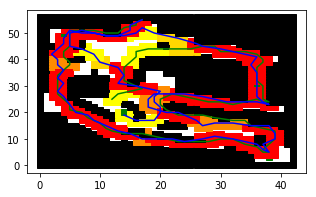

In [22]:
pylab.rcParams['figure.figsize'] = (5.0, 3.0)
DrawSimilarity("Result10t.txt", "Result16t.txt")

# Find most similar path

In [30]:
def FindMostSimilarPath(path, plot = True):
    completePath = resultDir + "/" + path
    
    if os.path.isfile(completePath):
        with open(completePath) as pathFile:
            data = json.load(pathFile)
            mapName = data["mapName"][0]
            array_position = data["position"]
            mapFile = GetOriginalMap(mapName)
            
    origin = (0.0,0.0)
    array_position = stringArray2listArrayOfMap(array_position, origin, mapName)
    
    index = 1
    finish = False
    
    min_distance = float('Inf') 
    max_similarity = 0
    mostSimilarFile = ""
    mostCloseFile = ""
    while(finish == False):
        if os.path.isfile(resultDir + "/" + "Result" + str(index) + "t.txt"):
            humanPath = resultDir + "/" + "Result" + str(index) + "t.txt"
            if completePath != humanPath:
                with open(humanPath) as human_file:
                    human_data = json.load(human_file)
                    if(human_data['mapName'][0] == mapName):
                        human_position = human_data['position']
                        
                        human_position = stringArray2listArrayOfMap(human_position, origin, mapName)
                        distance, path = fastdtw(array_position, human_position, dist=euclidean)
                        similarity = SimilarPercentage(path, array_position, human_position)
                        
                        if distance < min_distance:
                            min_distance = distance
                            mostCloseFile = humanPath
                            mostClosePath = human_position
                            close_dtw_path = path
                        
                        if similarity > max_similarity:
                            max_similarity = similarity
                            mostSimilarFile = humanPath
                            mostSimilarPath = human_position
                            similar_dtw_path = path
                        
            index = index + 1
        else:
            finish = True
            
    print("most close file: %s with distance %.2f" %(mostCloseFile, min_distance))
    print("most similar file: %s with similarity %.2f%%" %(mostSimilarFile, max_similarity * 100))
    
    if plot:
        
        if os.path.isfile(originalMapDir + "/" + mapFile):
            with open(originalMapDir + "/" + mapFile) as f:
                array = []
                content = f.readlines()
                content = [x.strip() for x in content]
                
        c = 1
        for drawline in [[mostClosePath, close_dtw_path], [mostSimilarPath, similar_dtw_path]]:
            plt.subplot(1, 2, c)
            
            # draw the original map
            j = 0
            for line in content:
                array = line.split(',')
                for i in range(len(array)):
                    a = int(array[i])
                    if a == 1:
                        plt.plot(i, len(content)-j, 'ks')

                    if a == 4:
                        plt.plot(i, len(content)-j , 'gs')

                j = j + 1 

            #draw the paths

            first_x, first_y = conv2Axis(array_position)
            second_x, second_y = conv2Axis(drawline[0])

            plt.plot(first_x, first_y, 'r-')
            plt.plot(second_x, second_y, 'b-')

            # draw DTW lines  
            for i in drawline[1]:
                fx, fy = array_position[i[0]]
                sx, sy = drawline[0][i[1]]

                plt.plot([fx, sx], [fy, sy], 'g-')
                
            c += 1
        plt.show()
    

most close file: C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/local_project/DownloadedResults/Result10t.txt with distance 542.17
most similar file: C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/local_project/DownloadedResults/Result2t.txt with similarity 63.95%


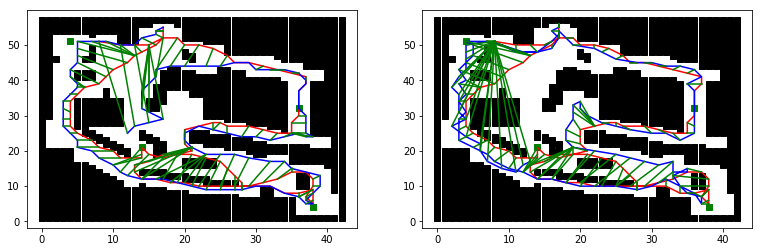

In [31]:
pylab.rcParams['figure.figsize'] = (13.0, 4.0)
FindMostSimilarPath("Result6t.txt")